# 1. Conclusion from EDA:
* Customer 1 has one single setpoint, majority of the data, compressor is highly correlated with door (lag 60 seconds correlation 0.96)
* Customer resets setpoint at the beginning of each day, thus the compressor is influenced by both door and setpoint
* Customer 3 has one single setpoint, but large period of missing data, in which was speculated as refrigerator being turned off (vacant time), so the compressor is influenced by both door and vacant time
* the relationship between compressor and the door can be modulated by setpoint

## 1.1 Parameters
* Since energy consumption is solely determined by the amount of the time the compressor is active, modeling compressor would solve the energy consumption
* From the observations from the three customers, compressor is modeled based on three factors
* 1. How the compressor relates to door, Pd. It would vary across customers and setpoints, so we have Pd1, Pd2, Pd3 for each customer, and it can vary by setpoint.
* 2. How many seconds does the compressor run when each time the setpoint is changed, per degree, setpoint_adjust_seconds_per_degree. This should vary across customer, but adjusting to a new setpoint cost a tiny amount of energy compare to the  monthly usage because it would only be done one time, so the customer difference in this is ignored for this problem.
* 3. The compressor/door relation can be influenced by the number of nonvacant days. It can be estimated in cusstomer 3.
* compressor: fraction of any given time aggregation the compressor is active
* door: fraction of any given time aggregation the door is open
* temp: refrigerator temperature at the time of setpoint change
* setpoint: the temperature that the refrigerator is change into at the setpoint change
* setpoint: the setpoint when the refrigerator is turned on after vacancy

## 1.2 Model compressor active seconds for a day
customer 1:  
compressor = (door * Pd) * 24 * 3600  
customer 2:  
compressor = (door * Pd) * 24 * 3600 + (temp - setpoint) * setpoint_adjust_seconds_per_degree  
customer 3: (only for nonvacant days)  
compressor = (door * Pd) * 24 * 3600

## 1.3 Parameters to estimate:
* Pd1 for customer1 under three setpoints [35, 40, 45]
* Pd2 for customer2 under three setpoints [35, 40, 45]
* Pd3 for customer3 under three setpoints [35, 40, 45]
* door1 for customer1
* door2 for customer2
* door3 for customer3
* Pd3 may also be influenced by the number of nonvacant days
* nonvacant days for customer3 in May, nonvacant_May

# 2 Import libraries, define functions, import data

In [1]:
import gzip
import json_lines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, scandir
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (20,10)
sns.set()
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def read_one_file(filename):
    data=[]
    for item in json_lines.reader(gzip.open(filename)):
        data.append(item)
    df = pd.DataFrame.from_dict(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp',inplace=True)
    return df

# plot the gap between timestamps
def plot_gap(df):
    df_gap = df.reset_index()
    df_gap['gap'] = df_gap['timestamp'].diff()
    df_gap['gap'] = df_gap['gap'].apply(lambda x: x.total_seconds())
    plt.plot(df_gap.index, df_gap.gap)
    
    # get the customer ID: uuid using month id: moid
def get_uuid(moid):
    uuid = []
    for filename in listdir('take_home_data_challenge/' + str(moid[0])):
        uuid.append(filename.split('.')[0])
    return uuid

# read all the files
def read_all_files(uuid, moid):
    df = []
    for customer in uuid:
        for month in moid:
            filename = 'take_home_data_challenge/' + str(month) + '/' + customer + '.jsonl.gz'
            print('load', filename)
            df.append(read_one_file(filename))
    return df

def get_dfs(df):
    # merge files for the same customer together in order
    df1 = pd.concat([df[0], df[1], df[2], df[3]])
    df2 = pd.concat([df[4], df[5], df[6], df[7]])
    df3 = pd.concat([df[8], df[9], df[10], df[11]])
    return df1, df2, df3

# plot a random time period when the door is open
def zoom_in_door(df):
    dfc = df.copy()
    dfc.reset_index(inplace=True)
    indics_door_open = dfc[dfc.door == 1].index
    n_door_open = len(indics_door_open)
    index_door_open = indics_door_open[random.randrange(n_door_open)]
    scaler = MinMaxScaler()
    dfc.set_index('timestamp',inplace=True)    
    plt.plot(dfc.index[index_door_open-100:index_door_open+100], 
             scaler.fit_transform(dfc[index_door_open-100:index_door_open+100]))
    plt.legend(dfc.columns)

def plot_dickey_fuller(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
def plot_dickey_fuller_df(df):
    df_day = df.resample('D').mean() 
    df_day = df_day.dropna()
    plot_dickey_fuller(df_day.door, lags=30)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s, df_series):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df_series, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_SARIMA(df, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = df.copy().rename(columns = {'door': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);

In [3]:
# month ID
moid = [1,2,3,4]
uuid = get_uuid(moid)
df = read_all_files(uuid, moid)

load take_home_data_challenge/1/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
load take_home_data_challenge/2/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
load take_home_data_challenge/3/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
load take_home_data_challenge/4/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
load take_home_data_challenge/1/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
load take_home_data_challenge/2/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
load take_home_data_challenge/3/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
load take_home_data_challenge/4/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
load take_home_data_challenge/1/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz
load take_home_data_challenge/2/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz
load take_home_data_challenge/3/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz
load take_home_data_challenge/4/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz


In [4]:
df1, df2, df3 = get_dfs(df)

# 3. Study customer 1
* Pd1 at one setpint
* compressor1 = door1 * Pd1

In [5]:
df1_day = df1.resample('D').mean()
df1_day.head()

,compressor,temp,door,roomTemp,setpoint
timestamp,,,,,
2019-01-01 00:00:00+00:00,0.014693,43.045450,0.014168,60.022513,43.0
2019-01-02 00:00:00+00:00,0.014353,43.045645,0.013533,60.216864,43.0
2019-01-03 00:00:00+00:00,0.014265,43.042507,0.014087,60.020911,43.0
2019-01-04 00:00:00+00:00,0.016840,43.051788,0.016319,60.000000,43.0
2019-01-05 00:00:00+00:00,0.013848,43.041662,0.013484,59.978066,43.0


<AxesSubplot:>

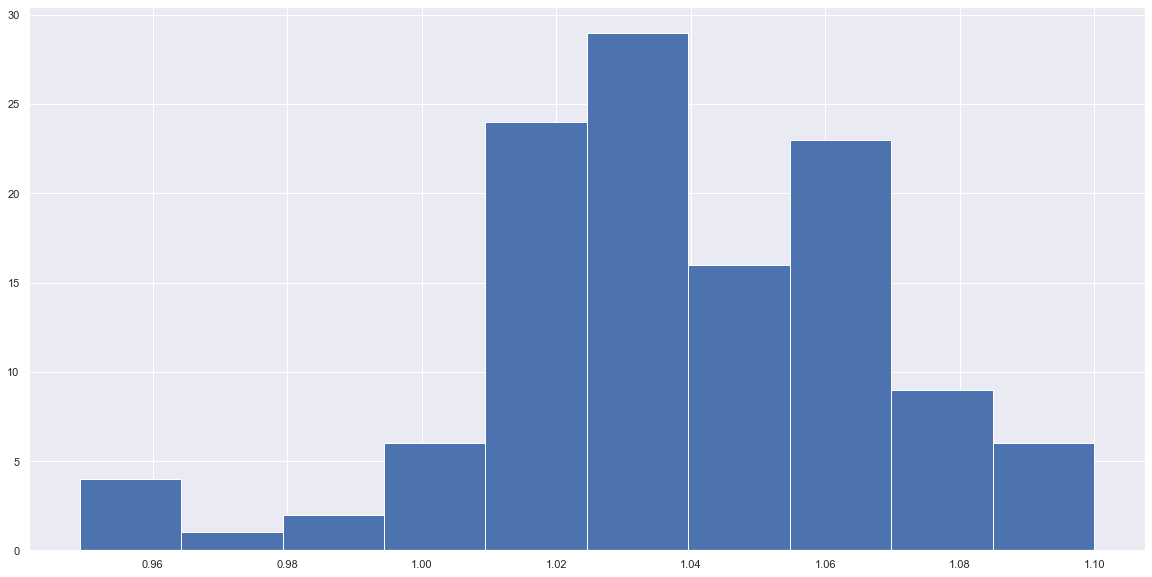

In [6]:
# calculate Pd1 using compressor and door based on day aggregates
# the resulted Pd1 has a normal distribution, thus the mean point of Pd1 is used as the parameter
df1_day['Pd1'] = df1_day.compressor/df1_day.door
plt.rcParams["figure.figsize"] = (20,10)
df1_day['Pd1'].hist()

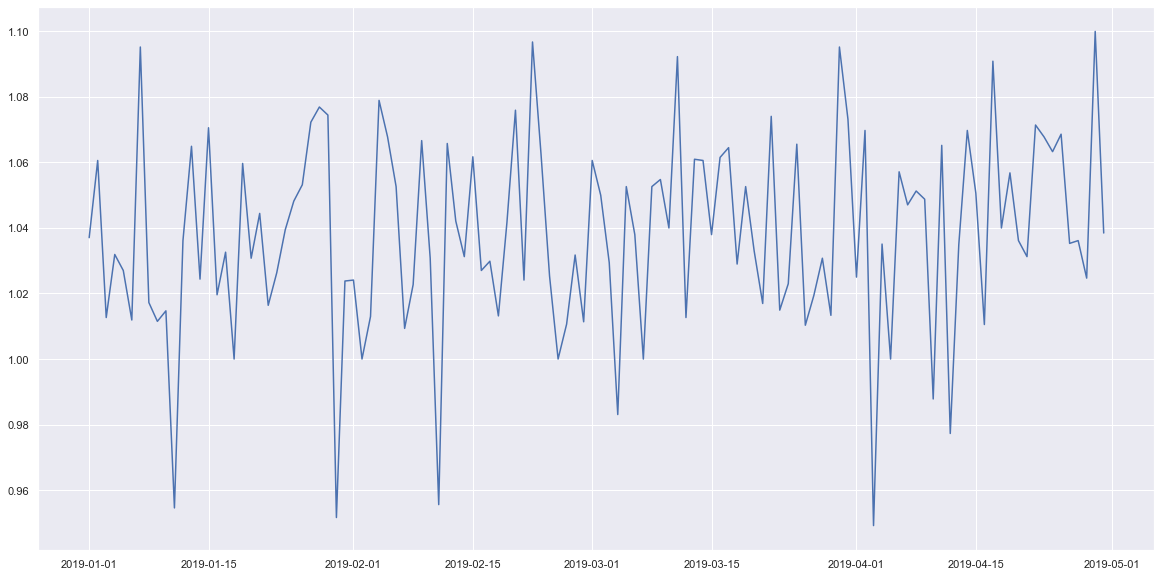

In [7]:
plt.plot(df1_day.index, df1_day.Pd1)

In [8]:
# This means every time when the door is open for 1 second, 
# the compressor would be active for an average of 1.037 seconds
# at customer1's setpoint 43
Pd1_43 = df1_day.Pd1.mean()
print(Pd1_43)
print(df1_day.Pd1.std())

1.037966347494091
0.030166341149655287


In [9]:
# check the value from aggregated calculation, pretty close to what we got
df1.compressor.sum()/df1.door.sum()

1.0376906318082788

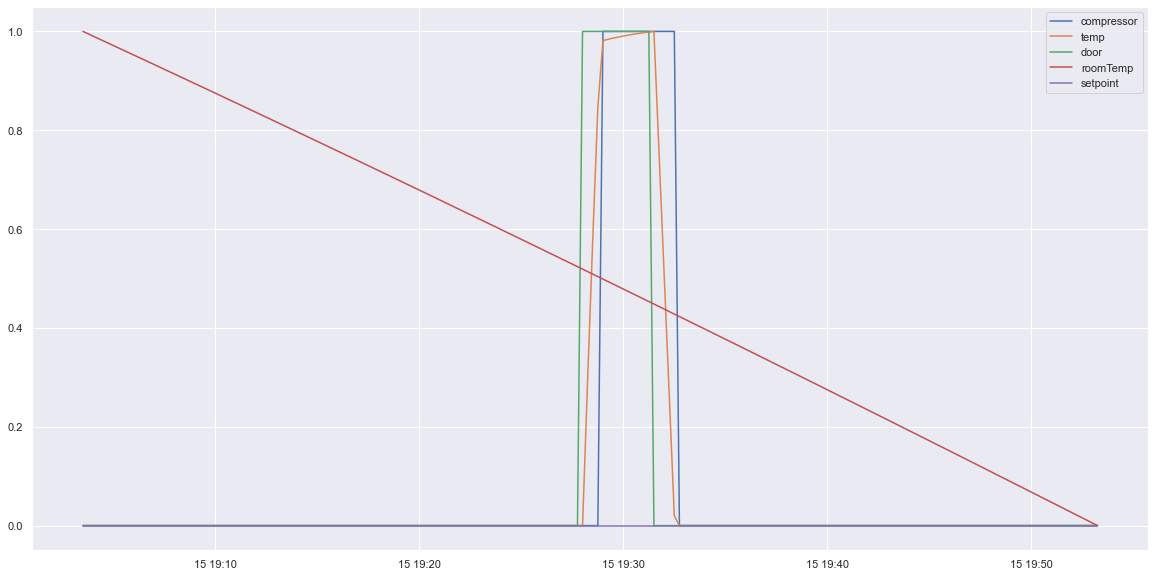

In [10]:
# verifying by a zoomed in plot
zoom_in_door(df1)

# 4. Study customer 2
* setpoint_adjust_seconds_per_degree
* Pd2
* compressor2 = door2 * Pd2 * 24 * 3600 + (temp - setpoint) * setpoint_adjust_seconds_per_degree

## 4.1, how long does the compressor need to be active for the refrigerator to set to a lower setpoint, specifically from 42 to 34

<AxesSubplot:xlabel='time'>

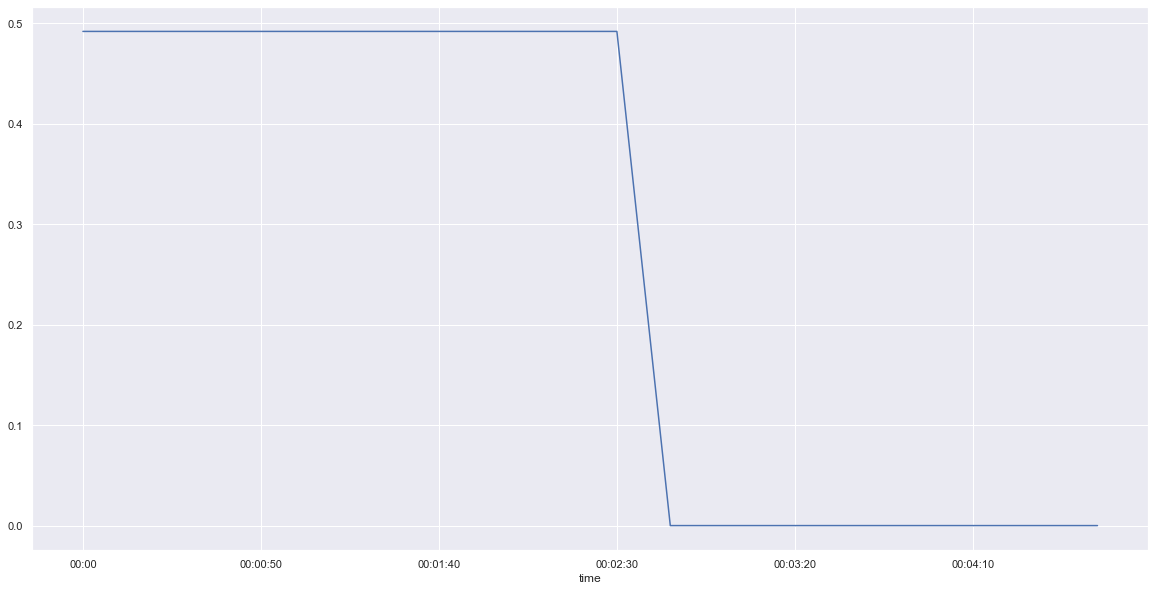

In [11]:
by_time = df2.groupby(df2.index.time).mean()
by_time.compressor[0:20].plot()

In [12]:
# It takes the compressor ~32.5 seconds to adjust the setpoint from 42 to 34, since there is 15 seconds between each point, subtract half of it 
setpoint_adjust_seconds = by_time[by_time.compressor==0].index[0].second - 7.5
setpoint_adjust_seconds

37.5

In [13]:
# For every degree decrease, the compressor needs to run ~4.7 seconds
setpoint_adjust_seconds_per_degree = setpoint_adjust_seconds/(42-34)
setpoint_adjust_seconds_per_degree

4.6875

In [14]:
df2_day = df2.resample('D').mean()
# set the temperature as the refrigerator temperator before changing the setpoint, 
# which is the setpoint from the previous day
df2_day['temp'] = df2_day.setpoint.shift(1)
df2_day.reset_index(inplace=True)
df2_day.loc[df2_day.index==0,'temp']=42
df2_day.head()

,timestamp,compressor,temp,door,roomTemp,setpoint
0,2019-01-01 00:00:00+00:00,0.049479,42.0,0.022049,73.0,34.0
1,2019-01-02 00:00:00+00:00,0.031944,34.0,0.017014,73.0,42.0
2,2019-01-03 00:00:00+00:00,0.052604,42.0,0.021181,73.0,34.0
3,2019-01-04 00:00:00+00:00,0.034549,34.0,0.018750,73.0,42.0
4,2019-01-05 00:00:00+00:00,0.058854,42.0,0.024653,73.0,34.0


In [15]:
# compensate for the compressor run for each day
df2_day['temp_decrease'] =  df2_day.temp - df2_day.setpoint
df2_day['compressor_total'] = df2_day['compressor'] * 24 * 3600 # convert daily mean to seconds
df2_day['compressor_calibrate'] = df2_day['temp_decrease'] * setpoint_adjust_seconds_per_degree #adjustment in seconds
df2_day['compressor_total_calibrated'] = df2_day['compressor_total'] + df2_day['compressor_calibrate']
df2_day.head()

,timestamp,compressor,temp,door,roomTemp,setpoint,temp_decrease,compressor_total,compressor_calibrate,compressor_total_calibrated
0,2019-01-01 00:00:00+00:00,0.049479,42.0,0.022049,73.0,34.0,8.0,4275.0,37.5,4312.5
1,2019-01-02 00:00:00+00:00,0.031944,34.0,0.017014,73.0,42.0,-8.0,2760.0,-37.5,2722.5
2,2019-01-03 00:00:00+00:00,0.052604,42.0,0.021181,73.0,34.0,8.0,4545.0,37.5,4582.5
3,2019-01-04 00:00:00+00:00,0.034549,34.0,0.018750,73.0,42.0,-8.0,2985.0,-37.5,2947.5
4,2019-01-05 00:00:00+00:00,0.058854,42.0,0.024653,73.0,34.0,8.0,5085.0,37.5,5122.5


# 4.2 How is Pd2 influenced by setpoint

In [16]:
# calculate the Pd2 for each day
df2_day['door_total'] =  df2_day['door'] * 24 * 3600 
df2_day['Pd2'] = df2_day.compressor_total/df2_day.door_total
df2_day.head()

,timestamp,compressor,temp,door,roomTemp,setpoint,temp_decrease,compressor_total,compressor_calibrate,compressor_total_calibrated,door_total,Pd2
0,2019-01-01 00:00:00+00:00,0.049479,42.0,0.022049,73.0,34.0,8.0,4275.0,37.5,4312.5,1905.0,2.244094
1,2019-01-02 00:00:00+00:00,0.031944,34.0,0.017014,73.0,42.0,-8.0,2760.0,-37.5,2722.5,1470.0,1.877551
2,2019-01-03 00:00:00+00:00,0.052604,42.0,0.021181,73.0,34.0,8.0,4545.0,37.5,4582.5,1830.0,2.483607
3,2019-01-04 00:00:00+00:00,0.034549,34.0,0.018750,73.0,42.0,-8.0,2985.0,-37.5,2947.5,1620.0,1.842593
4,2019-01-05 00:00:00+00:00,0.058854,42.0,0.024653,73.0,34.0,8.0,5085.0,37.5,5122.5,2130.0,2.387324


In [17]:
# It looks like there is a big difference between Pd2 with different setpoint
df2_day[['Pd2', 'setpoint']].groupby(['setpoint']).mean()

,Pd2
setpoint,
34.0,2.369410
42.0,1.848526


In [18]:
df2_day[['Pd2', 'setpoint']].groupby(['setpoint']).std()

,Pd2
setpoint,
34.0,0.073490
42.0,0.042335


In [19]:
c2_setpoints = df2.setpoint.unique()
c2_setpoints.sort()
c2_setpoints

array([34., 42.])

In [20]:
c2_setpoints = c2_setpoints.reshape(-1,1)
c2_setpoints

array([[34.],
       [42.]])

In [21]:
Pd2_at_setpoint = df2_day[['Pd2', 'setpoint']].groupby(['setpoint']).mean().values
Pd2_at_setpoint

array([[2.36940974],
       [1.84852554]])

In [22]:
reg_setpoint_Pd2 = LinearRegression().fit(c2_setpoints, Pd2_at_setpoint)

In [23]:
setpoints = [35, 40, 45]
Pd2 = reg_setpoint_Pd2.predict(np.array(setpoints).reshape(-1,1)).flatten()
Pd2

array([2.30429921, 1.97874659, 1.65319397])

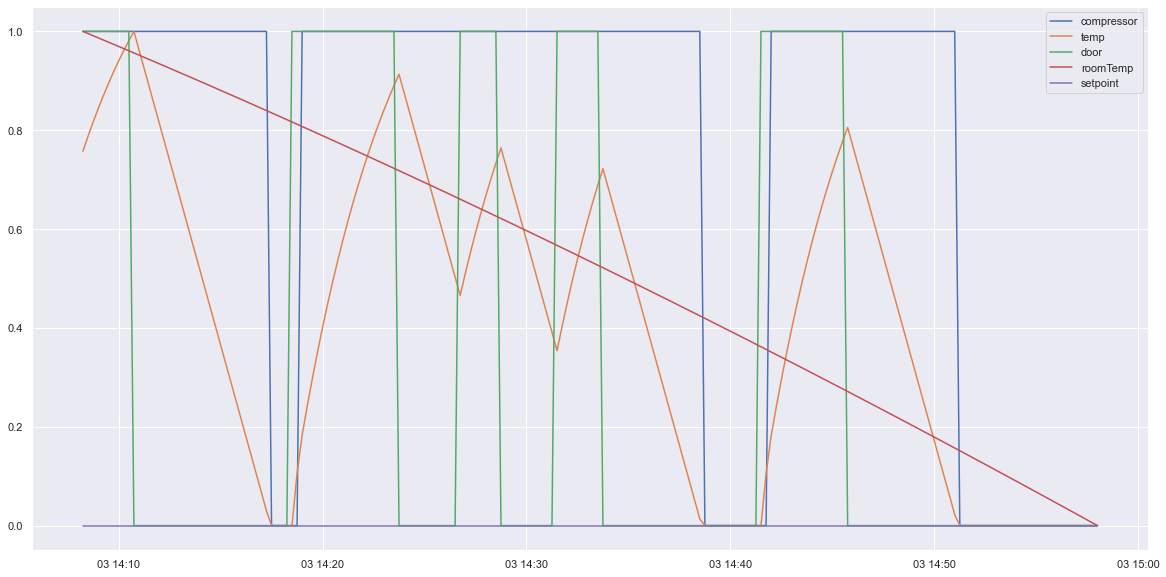

In [24]:
# Verify Pd2 by zooming in a door opening event
zoom_in_door(df2)

# 5. Customer 3
* vacant_May, estimated vacant days in May
* Pd3 can be influenced by nonvacant days
* compressor3 = door3 * Pd3

## 5.1 Split the data by the vacancy period and calculat Pd3 for each period

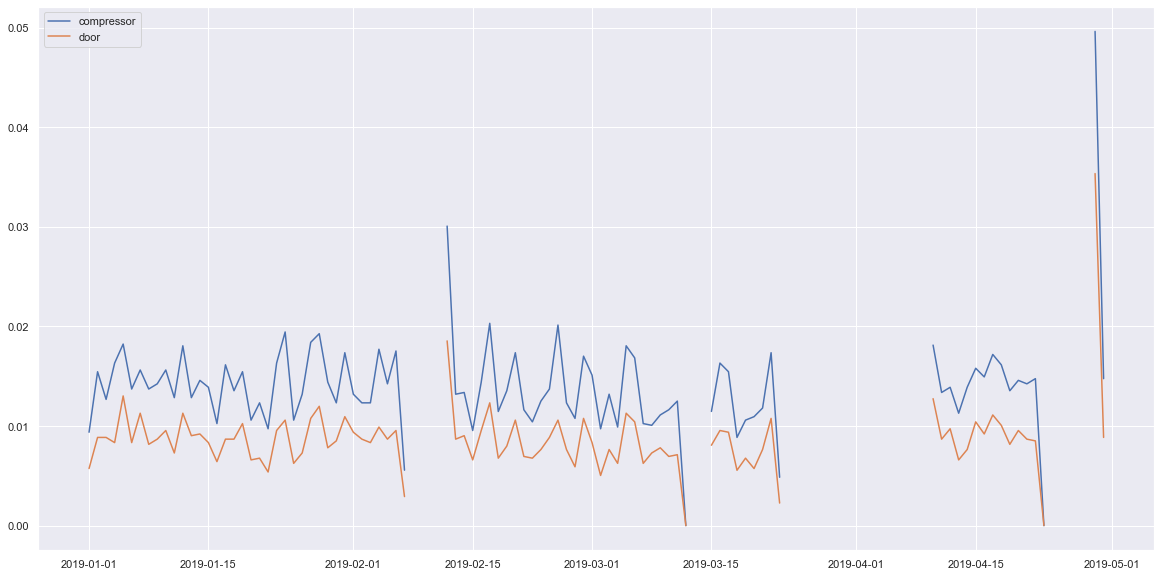

In [25]:
# Customer 3 has 4 vacant period, so 5 piece of data can be used to estimate the parameters
df3_day = df3.resample('D').mean()

plt.plot(df3_day.index, df3_day[['compressor','door']])
plt.legend(['compressor','door'])

In [26]:
df3c = df3.copy()
df3c.reset_index(inplace=True)
df3c['gap'] = df3c.timestamp.diff().astype('timedelta64[D]')
df3c.head()

,timestamp,compressor,temp,door,roomTemp,setpoint,gap
0,2019-01-01 00:00:00+00:00,0.0,37.0,0.0,63.303806,37.0,NaN
1,2019-01-01 00:00:15+00:00,0.0,37.0,0.0,63.308822,37.0,0.0
2,2019-01-01 00:00:30+00:00,0.0,37.0,0.0,63.313844,37.0,0.0
3,2019-01-01 00:00:45+00:00,0.0,37.0,0.0,63.318872,37.0,0.0
4,2019-01-01 00:01:00+00:00,0.0,37.0,0.0,63.323904,37.0,0.0


In [27]:
gaps = list(df3c.gap.unique())
gaps = [x for x in gaps if str(x)!='nan' and x!=0]
gaps

[4.0, 3.0, 17.0, 6.0]

In [28]:
df3_split = []
early_bound = 0
for gap in gaps:
    this_index = df3c[df3c.gap == gap].index.values[0]
    df3_split.append(df3[early_bound:this_index])
    early_bound = this_index
df3_split

[                           compressor  temp  door   roomTemp  setpoint
 timestamp                                                             
 2019-01-01 00:00:00+00:00         0.0  37.0   0.0  63.303806      37.0
 2019-01-01 00:00:15+00:00         0.0  37.0   0.0  63.308822      37.0
 2019-01-01 00:00:30+00:00         0.0  37.0   0.0  63.313844      37.0
 2019-01-01 00:00:45+00:00         0.0  37.0   0.0  63.318872      37.0
 2019-01-01 00:01:00+00:00         0.0  37.0   0.0  63.323904      37.0
 ...                               ...   ...   ...        ...       ...
 2019-02-07 15:42:30+00:00         0.0  37.0   0.0  66.701529      37.0
 2019-02-07 15:42:45+00:00         0.0  37.0   0.0  66.694560      37.0
 2019-02-07 15:43:00+00:00         0.0  37.0   0.0  66.687594      37.0
 2019-02-07 15:43:15+00:00         0.0  37.0   0.0  66.680629      37.0
 2019-02-07 15:43:30+00:00         0.0  37.0   0.0  66.673665      37.0
 
 [216895 rows x 5 columns],
                            compre

In [29]:
df3_split_day = []
for data in df3_split:
    df3_split_day.append(data.resample('D').mean())

## 5.2 Calculate the Pd3 for each period of data

In [30]:
for data in df3_split_day:
    data['Pd3'] = data.compressor/data.door

In [31]:
# Pd3 at each consecutive non-vacant time
Pd3_split = [data.Pd3.mean() for data in df3_split_day]
Pd3_split

[1.649484407525184, 1.632725177203083, 1.682938897347735, 1.5977441776643457]

In [32]:
# The third period has the largest variance of Pd3
Pd3_split_std = [data.Pd3.std() for data in df3_split_day]
Pd3_split_std

[0.15626159541805568,
 0.1335552913195323,
 0.21766716016872278,
 0.11662545634581924]

In [33]:
# drill in the variation: on day 3/23 there is a large Pd3
df3_split_day[2]

,compressor,temp,door,roomTemp,setpoint,Pd3
timestamp,,,,,,
2019-03-15 00:00:00+00:00,0.011465,37.041348,0.008068,63.638872,37.0,1.421053
2019-03-16 00:00:00+00:00,0.016319,37.078829,0.009549,67.900000,37.0,1.709091
2019-03-17 00:00:00+00:00,0.015451,37.070942,0.009375,67.900000,37.0,1.648148
2019-03-18 00:00:00+00:00,0.008854,37.040579,0.005556,67.900000,37.0,1.593750
2019-03-19 00:00:00+00:00,0.010590,37.043360,0.006771,67.900000,37.0,1.564103
2019-03-20 00:00:00+00:00,0.010937,37.056490,0.005729,67.900000,37.0,1.909091
2019-03-21 00:00:00+00:00,0.011806,37.045037,0.007639,67.900000,37.0,1.545455
2019-03-22 00:00:00+00:00,0.017361,37.086666,0.010764,67.900000,37.0,1.612903
2019-03-23 00:00:00+00:00,0.004850,37.020527,0.002263,70.900303,37.0,2.142857


<AxesSubplot:xlabel='timestamp'>

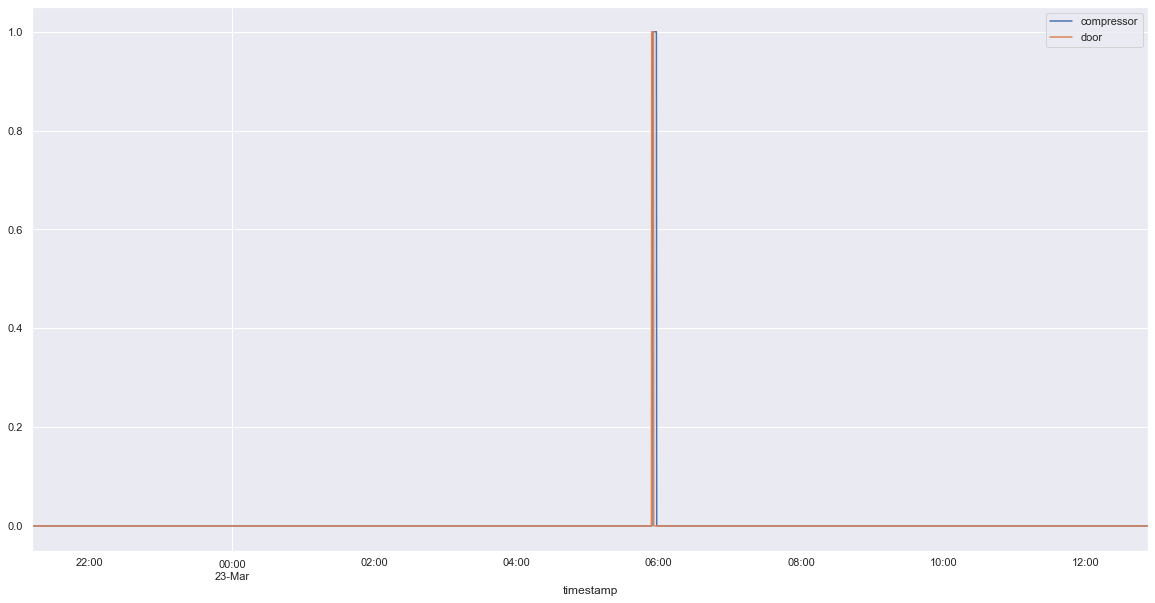

In [34]:
# there was only a brief encounter of compressor and door
df3_split[2][['compressor','door']][42000:].plot()

<AxesSubplot:xlabel='timestamp'>

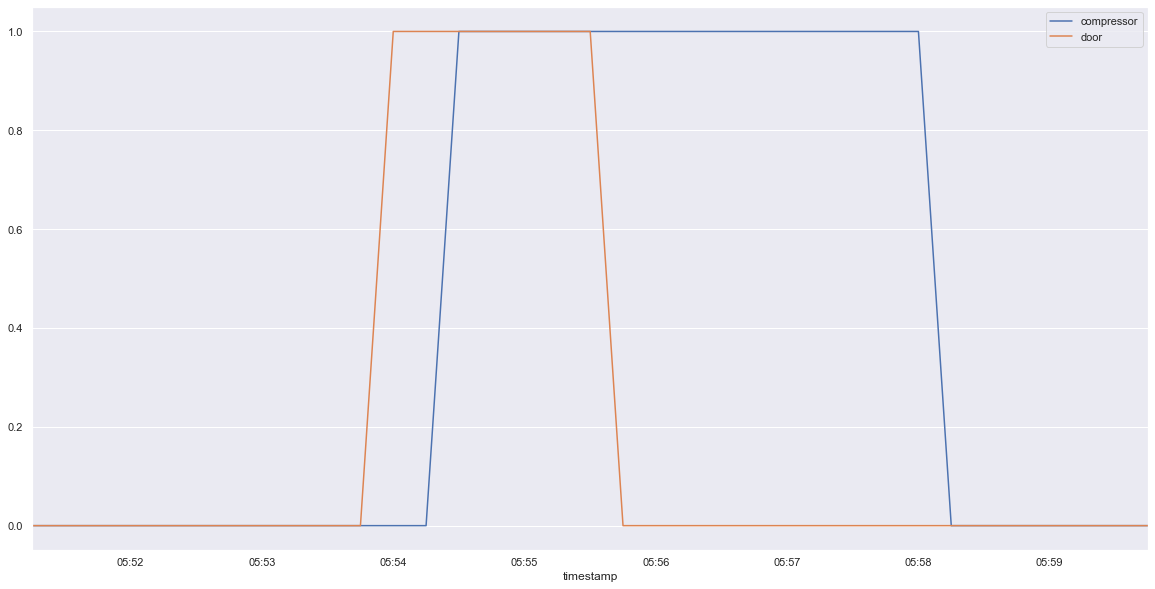

In [35]:
# the door was opened for extra long, about 2 minutes, and the compressor was on for about 4 minutes
# it should be treated as an outlier
df3_split[2][['compressor','door']][44080:44115].plot()

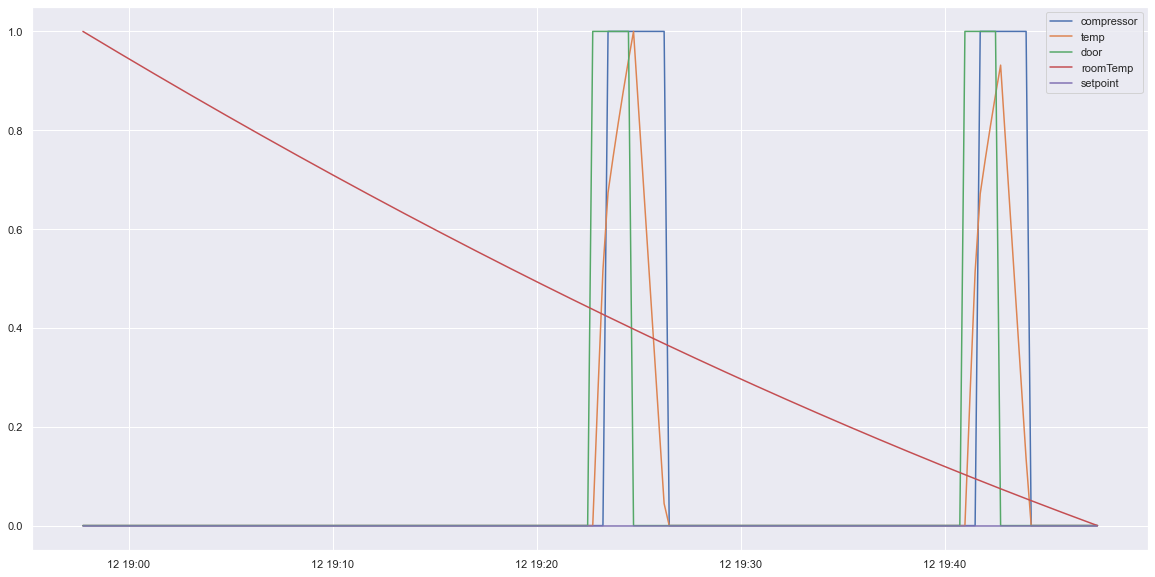

In [36]:
# Pd3 is in between Pd1 and Pd2, but has a very large standard deviation. 
# Zoom in
zoom_in_door(df3)

## 5.3 Verify every time when the refrigerator was turned on from off, it kept its setpoint before it was turned off, so no one time compressor action when it was turned on

In [37]:
for gap in gaps:
    this_index = df3c[df3c.gap == gap].index.values[0]
    print(df3c[this_index:this_index+1])

                       timestamp  compressor  temp  door   roomTemp  setpoint  \
216895 2019-02-12 07:22:30+00:00         0.0  37.0   0.0  73.820615      37.0   

        gap  
216895  4.0  
                       timestamp  compressor  temp  door   roomTemp  setpoint  \
377255 2019-03-15 14:11:15+00:00         0.0  37.0   0.0  69.272225      37.0   

        gap  
377255  3.0  
                       timestamp  compressor  temp  door   roomTemp  setpoint  \
423023 2019-04-10 09:17:15+00:00         0.0  37.0   0.0  74.381597      37.0   

         gap  
423023  17.0  
                       timestamp  compressor  temp  door   roomTemp  setpoint  \
496023 2019-04-29 17:52:15+00:00         0.0  37.0   0.0  63.461828      37.0   

        gap  
496023  6.0  


## 5.4 Predict vacant days for May for customer 3

In [38]:
# count the number of vacant days for each month
df3_day_vacant = df3_day[(df3_day.compressor.isnull())]
df3_day_vacant['vcount'] = 1
vacancy_count = df3_day_vacant.resample('M').sum()
vacancy_count

,compressor,temp,door,roomTemp,setpoint,vcount
timestamp,,,,,,
2019-02-28 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,4
2019-03-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,10
2019-04-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,14


In [39]:
# add that January there was no vacancy
vacancy_count_list = [0] + vacancy_count.vcount.to_list()
vacant = np.array(vacancy_count_list).reshape(-1,1)
month = np.array([1, 2, 3, 4]).reshape(-1,1)
print(vacant)
print(month)

[[ 0]
 [ 4]
 [10]
 [14]]
[[1]
 [2]
 [3]
 [4]]


In [40]:
reg_month_vacant = LinearRegression().fit(month, vacant)

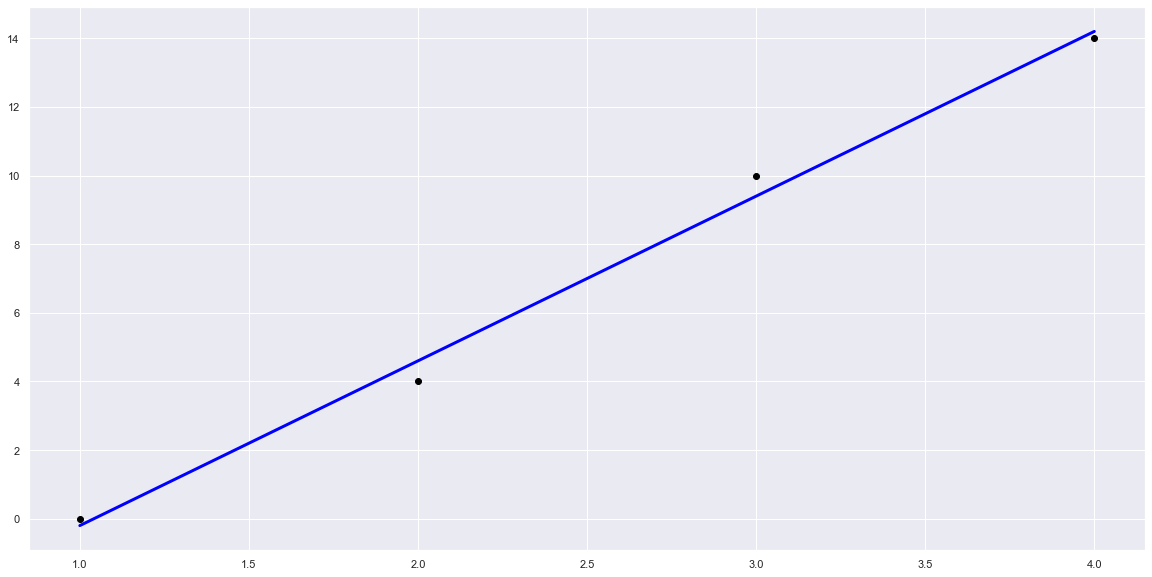

In [41]:
# plot the linear fitted line for vacancy
plt.scatter(month, vacant,  color='black')
plt.plot(month, reg_month_vacant.predict(month), color='blue', linewidth=3)

In [42]:
# The estimated vacancy for May
vacancy_May = reg_month_vacant.predict([[5]])[0][0]
vacancy_May

18.999999999999996

## 5.5 Pd3 may be influenced by number of nonvacanct days

In [43]:
total_days = np.array([31,28,31,30])
nonvacant = total_days - np.array(vacancy_count_list)
nonvacant

array([31, 24, 21, 16])

In [44]:
nonvacant = nonvacant.reshape(-1,1)

In [45]:
Pd3_split = np.array(Pd3_split).reshape(-1,1)
Pd3_split

array([[1.64948441],
       [1.63272518],
       [1.6829389 ],
       [1.59774418]])

In [46]:
reg_nonvacant_Pd3 = LinearRegression().fit(nonvacant, Pd3_split)

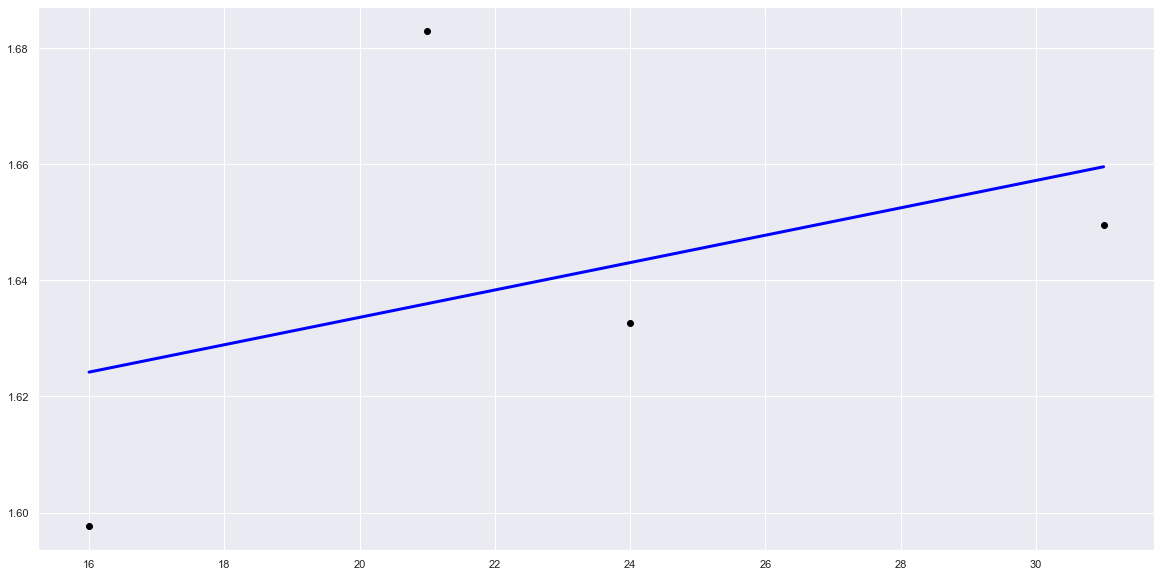

In [47]:
# plot the linear fitted line for vacancy, linear regression is not a great fit, but maybe better than using the mean of Pd3
plt.scatter(nonvacant, Pd3_split,  color='black')
plt.plot(nonvacant,reg_nonvacant_Pd3.predict(nonvacant), color='blue', linewidth=3)

In [48]:
# predicted Pd3 in May based on predicted number of vacancy at the one setpoint 37
Pd3_37 = reg_nonvacant_Pd3.predict([[31-vacancy_May]])[0][0]
Pd3_37

1.6147600514635165

# 6. Estimate Pd1 and Pd3 under different setpoints
* We know the Pd~setpoint relationship for customer 2, in the linear regression model reg_setpoint_Pd2
* Assume the Pd change across setpoints is proportional to Pd for each customer

In [49]:
setpoint_customer1 = df1.setpoint.unique()
setpoint_customer3 = df3.setpoint.unique()
setpoint_customer1, setpoint_customer3

(array([43.]), array([37.]))

In [50]:
# Cusstomer 2 would have the following Pd2 at the setpoints for customer 1 and 3
Pd2_43, Pd2_37 = reg_setpoint_Pd2.predict([setpoint_customer1, setpoint_customer3])
Pd2_43 = Pd2_43[0]
Pd2_37 = Pd2_37[0]
Pd2_43, Pd2_37

(1.7834150174848071, 2.1740781632390207)

In [51]:
# Customer 1 and 3 have the following Pd at their setpoint
Pd1_43, Pd3_37

(1.037966347494091, 1.6147600514635165)

In [52]:
# customer2 have the following Pd2 under different setpoints
setpoints = [35, 40, 45]
Pd2 = reg_setpoint_Pd2.predict(np.array(setpoints).reshape(-1,1))
Pd2 = Pd2.flatten()
Pd2

array([2.30429921, 1.97874659, 1.65319397])

In [53]:
# interpolate Pd1
Pd1 = Pd1_43/Pd2_43*Pd2
Pd1

array([1.34112644, 1.15165138, 0.96217632])

In [54]:
# interpolate Pd3
Pd3 = Pd3_37/Pd2_37*Pd2
Pd3

array([1.71147955, 1.46968081, 1.22788206])

# 7. Estimate the door habit in May for each customer
* Now we have the parameters to estimate compressor for each customer for each setpoint (35, 40, 45)
* compressor = door * Pd
* We just need to estimate the door behavior for the month of May for each customer

## 7.1, check the stationary and seasonality effect of door in all three customers using Dickey-Fuller
* Observations, all door behaviors are stationary, so it fluctuates around the mean

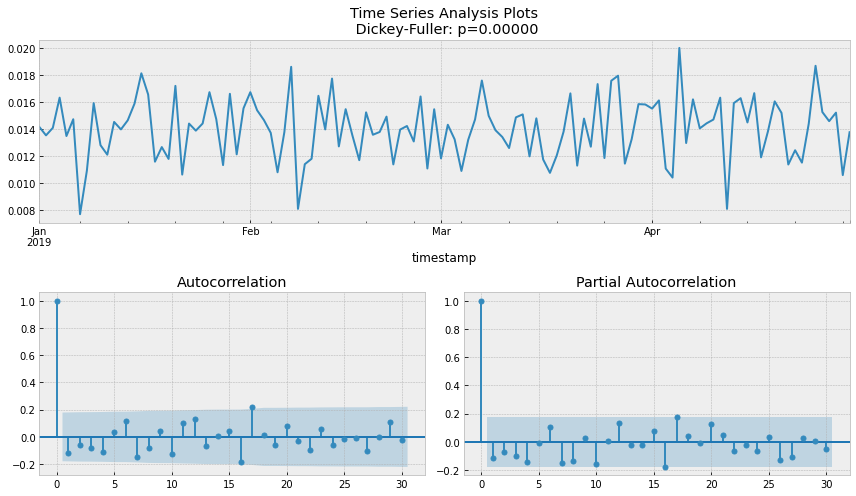

In [61]:
plot_dickey_fuller_df(df1)

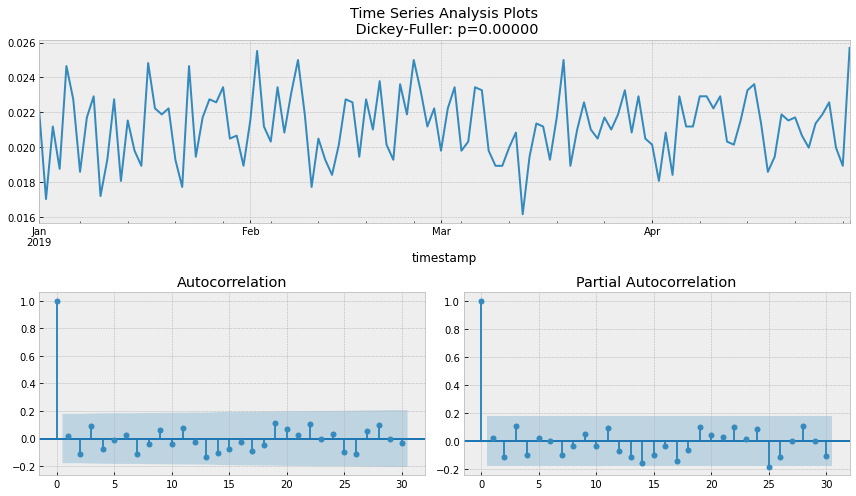

In [292]:
plot_dickey_fuller_df(df2)

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


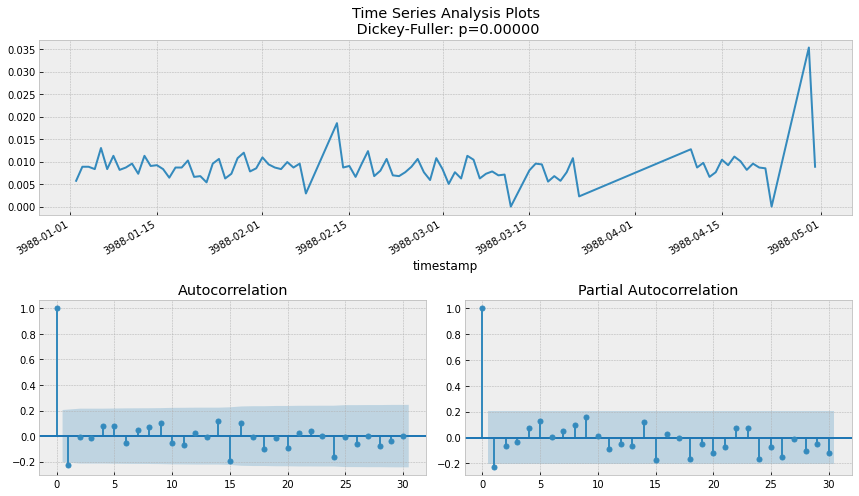

In [295]:
plot_dickey_fuller_df(df3)

## 7.2. test a ARIMA model to predict the door behavior
* Observation, it worked poorly

In [303]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

result_table = optimize_SARIMA(parameters_list, d, D, s, df1_day.door)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df1_day.door, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                              door   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood                 519.507
Date:                           Sun, 15 Nov 2020   AIC                          -1033.014
Time:                                   11:29:30   BIC                          -1024.806
Sample:                               01-01-2019   HQIC                         -1029.683
                                    - 04-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9994      4.482     -0.223      0.824      -9.783       7.784
ma.S.L5       -0.9999      0.037    -26.77

In [314]:
best_model

2019-05-01 00:00:00+00:00    0.014896
2019-05-02 00:00:00+00:00    0.013916
2019-05-03 00:00:00+00:00    0.013620
2019-05-04 00:00:00+00:00    0.014531
2019-05-05 00:00:00+00:00    0.014342
2019-05-06 00:00:00+00:00    0.014915
2019-05-07 00:00:00+00:00    0.013935
2019-05-08 00:00:00+00:00    0.013639
2019-05-09 00:00:00+00:00    0.014550
2019-05-10 00:00:00+00:00    0.014361
2019-05-11 00:00:00+00:00    0.014934
2019-05-12 00:00:00+00:00    0.013954
2019-05-13 00:00:00+00:00    0.013658
2019-05-14 00:00:00+00:00    0.014569
2019-05-15 00:00:00+00:00    0.014380
2019-05-16 00:00:00+00:00    0.014953
2019-05-17 00:00:00+00:00    0.013973
2019-05-18 00:00:00+00:00    0.013677
2019-05-19 00:00:00+00:00    0.014588
2019-05-20 00:00:00+00:00    0.014399
2019-05-21 00:00:00+00:00    0.014972
2019-05-22 00:00:00+00:00    0.013992
2019-05-23 00:00:00+00:00    0.013696
2019-05-24 00:00:00+00:00    0.014607
2019-05-25 00:00:00+00:00    0.014418
2019-05-26 00:00:00+00:00    0.014991
2019-05-27 0

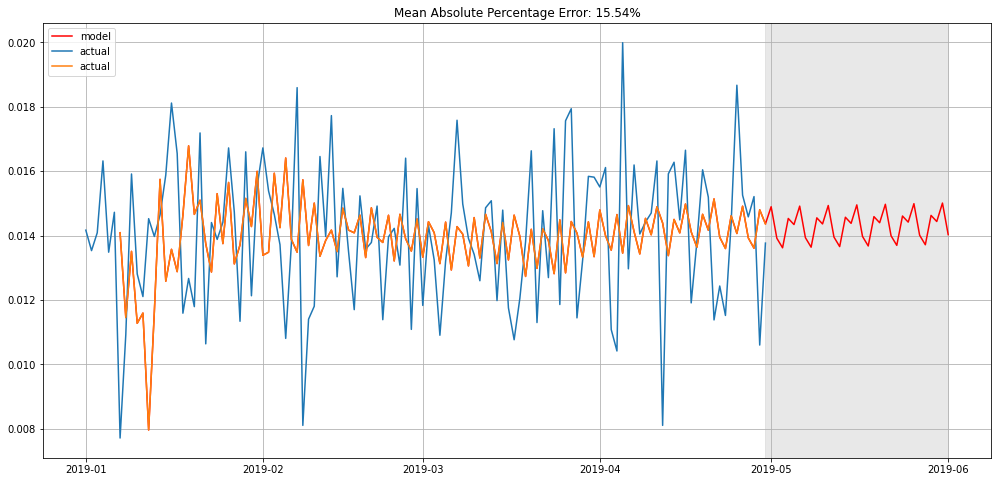

In [318]:
plot_SARIMA(df1_day[['door']], best_model, 31)
print(best_model.predict(start=df1_day.door.shape[0], end=df1_day.door.shape[0] + 31))
print(mean_absolute_percentage_error(df1_day.door[s+d:], best_model.fittedvalues[s+d:]))

In [55]:
# Arima is doing a pretty poor job. 
# since there is no seasonality in the door behavior, we will just use the averaged door behavior for Jaunary to April as the Pd for May
door1 = df1.door.mean()
door2 = df2.door.mean()
door3 = df3.door.mean()

# 8. Prediction
* There is only 1 setpoint change for each customer for May, so sigma can be removed
* To make predictions on three setpoints for each customer for May, the fomular is as follow:
compressor_in_seconds = door * Pd * (total_days_in_May - vacancy_in_May) * 24 * 3600 + (temp - setpoint)* setpoint_adjust_seconds_per_degree
* For customer 1 and 2 there is no predicted vacancy
* For customer 3, need to consider the vacancy factor
* Already calculated Pd1, Pd2, Pd3 for the three setpoints

In [56]:
door = np.array([door1, door2, door3])
total_days_in_May = 31
vacancy_in_May = np.array([0, 0, vacancy_May])
temp = np.array([df1.temp[-1], df2.temp[-1], df3.temp[-1]]) #the last temperature of April for each customer
temp

array([43., 42., 37.])

In [57]:
Pd = [Pd1, Pd2, Pd3]
Pd

[array([1.34112644, 1.15165138, 0.96217632]),
 array([2.30429921, 1.97874659, 1.65319397]),
 array([1.71147955, 1.46968081, 1.22788206])]

In [58]:
setpoint_adjust_seconds_per_degree # it probably varies across customers but it's a tiny part of the monthly usage, ignore the difference for now

4.6875

In [60]:
prediction = []
for i in [0,1,2]:
    for setpint_index, setpoint in enumerate(setpoints):
        compressor_total_hours = door[i] * Pd[i][setpint_index] * (total_days_in_May - vacancy_in_May[i]) *24
        compressor_total_seconds = compressor_total_hours * 3600 + (temp[i] - setpoint) * setpoint_adjust_seconds_per_degree 
        print('customer',str(i+1), 'setpoint',str(setpoint),'compressor active total hours in May', compressor_total_hours)
        energy = compressor_total_seconds/3600 * 0.2 # convert to kWh
        prediction.append([uuid[i],setpoint,energy])
prediction

customer 1 setpoint 35 compressor active total hours in May 13.987182656907454
customer 1 setpoint 40 compressor active total hours in May 12.011066032184091
customer 1 setpoint 45 compressor active total hours in May 10.03494940746073
customer 2 setpoint 35 compressor active total hours in May 36.37888377549969
customer 2 setpoint 40 compressor active total hours in May 31.23925567590222
customer 2 setpoint 45 compressor active total hours in May 26.099627576304755
customer 3 setpoint 35 compressor active total hours in May 4.268390966817051
customer 3 setpoint 40 compressor active total hours in May 3.665350414817058
customer 3 setpoint 45 compressor active total hours in May 3.062309862817065


[['de58b445-cfe9-4d0d-adae-5bef928a9dd0', 35, 2.7995198647148243],
 ['de58b445-cfe9-4d0d-adae-5bef928a9dd0', 40, 2.4029944564368186],
 ['de58b445-cfe9-4d0d-adae-5bef928a9dd0', 45, 2.0064690481588126],
 ['8b916a17-57b0-4449-bcaf-8f2d16c00bf7', 35, 7.277599671766605],
 ['8b916a17-57b0-4449-bcaf-8f2d16c00bf7', 40, 6.248371968513777],
 ['8b916a17-57b0-4449-bcaf-8f2d16c00bf7', 45, 5.219144265260951],
 ['09ac4a10-7e8e-40f3-a327-1f93a5cf2383', 35, 0.8541990266967437],
 ['09ac4a10-7e8e-40f3-a327-1f93a5cf2383', 40, 0.7322888329634116],
 ['09ac4a10-7e8e-40f3-a327-1f93a5cf2383', 45, 0.6103786392300796]]

In [61]:
prediction_df = pd.DataFrame(prediction, columns = ['uuid','setpoint','predictedUsage'])
prediction_df

,uuid,setpoint,predictedUsage
0,de58b445-cfe9-4d0d-adae-5bef928a9dd0,35,2.799520
1,de58b445-cfe9-4d0d-adae-5bef928a9dd0,40,2.402994
2,de58b445-cfe9-4d0d-adae-5bef928a9dd0,45,2.006469
3,8b916a17-57b0-4449-bcaf-8f2d16c00bf7,35,7.277600
4,8b916a17-57b0-4449-bcaf-8f2d16c00bf7,40,6.248372
5,8b916a17-57b0-4449-bcaf-8f2d16c00bf7,45,5.219144
6,09ac4a10-7e8e-40f3-a327-1f93a5cf2383,35,0.854199
7,09ac4a10-7e8e-40f3-a327-1f93a5cf2383,40,0.732289
8,09ac4a10-7e8e-40f3-a327-1f93a5cf2383,45,0.610379


In [62]:
prediction_df.to_csv('prediction.csv', index=False)